In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import math

import ipdb


In [2]:
class BlankModel(nn.Module):
    
    def __init__(self):
        super(BlankModel, self).__init__()
        self.fc = nn.Linear(2, 2)
        
    def foward(self, x):
        x = self.fc(x)
        return x
net = BlankModel()

In [93]:
# define loss and optimizer
import torch.optim as optim
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum=0.9, nesterov= True, weight_decay= 0.01)

# defining n_epochs
n_epochs = 10

In [106]:
class STLR(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_max, T, ratio = 32, cut_frac = 0.1,  last_epoch = -1):
        # T should be in multiples of 10 as a general rule
        self.ratio = ratio
        self.cut_frac = cut_frac
        self.lr_max = lr_max
        self.current_epoch = last_epoch
        self.t = self.current_epoch
        
        self.cut = max(math.floor(T*self.cut_frac),1)
        
        self.lr_history = []
        
        super(STLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        #ipdb.set_trace()
        if self.t < self.cut:
            p = self.t/self.cut
        else:
            p = 1- ((self.t-self.cut)/(self.cut*(1/self.cut_frac-1)))
        
        new_lr = [base_lr*(1+p*(self.ratio-1))/self.ratio for base_lr in self.base_lrs]
        self.lr_history.append(new_lr) 
        
        return new_lr

    def step(self, epoch=None):
        if epoch is None:
        
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        self.current_epoch += 1
        self.t = self.current_epoch
        
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline

In [108]:
def simulate_lrs(epochs):
    
    model = BlankModel()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    scheduler = STLR(optimizer, lr_max = learning_rate, T = epochs, ratio = 32, cut_frac = 0.1 )

    for i in range(epochs):
        scheduler.step()
        lr = optimizer.param_groups[0]['lr']
        print(lr)
    
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot([x[0] for x in scheduler.lr_history])
    ax.set_yscale("log")
    plt.show()

0.01
0.009461805555555557
0.008923611111111111
0.008385416666666668
0.007847222222222222
0.007309027777777778
0.0067708333333333336
0.00623263888888889
0.005694444444444445
0.00515625
0.004618055555555555
0.0040798611111111105
0.003541666666666667
0.003003472222222222
0.0024652777777777776
0.001927083333333333
0.0013888888888888896
0.0008506944444444447
0.0003125
-0.00022569444444444468


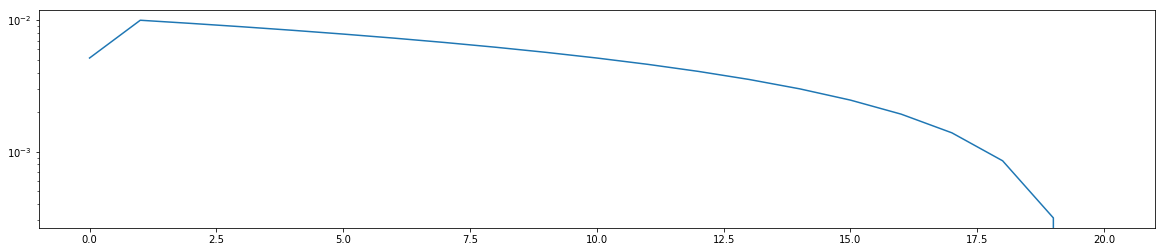

In [109]:
simulate_lrs(20)


In [ ]:
# LR scheduler
# general practice: lr_max = 0.01, T = 10, ratio = 32, cut_frac = 0.1
scheduler = STLR(optimizer, lr_max = learning_rate, T = n_epochs, ratio = 32, cut_frac = 0.1 )
